### Week 12
### DSC 650
### Abed Tabbalat

In [1]:
# Mounting drive
import os
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/My Drive/DSC650/Original/dsc650/assignments/assignment12')
!pwd

Mounted at /content/drive
/content/drive/My Drive/DSC650/Original/dsc650/assignments/assignment12


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
from keras import layers
tf.compat.v1.disable_eager_execution()
from keras.datasets import mnist
from tensorflow.keras.models import Model
from pathlib import Path
from scipy.stats import norm

## Assignment 12

In [3]:
# Define image shape, batch size, and latent dimension
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

# Define input layer with specified shape
input_img = keras.Input(shape=img_shape)

# Define encoder layers with convolutional and dense layers
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)  # Get shape of output before flattening
x = layers.Flatten()(x)  # Flatten output
x = layers.Dense(32, activation='relu')(x)  # Add dense layer with ReLU activation

# Define mean and log variance layers for the latent variables
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [4]:
# Define sampling function for latent variables
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
  # Sample from normal distribution with shape of z_mean and standard deviation of 1
  
  return z_mean + K.exp(z_log_var) * epsilon  # Return reparameterized latent variables

# Apply the sampling function to z_mean and z_log_var layers
z = layers.Lambda(sampling)([z_mean, z_log_var])

# Define decoder layers with dense, reshape, and transposed convolutional layers
decoder_input = layers.Input(K.int_shape(z)[1:])  # Define input layer with shape of z

x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
# Add dense layer with ReLU activation

x = layers.Reshape(shape_before_flattening[1:])(x)  # Reshape output

x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
# Add transposed convolutional layer with ReLU activation and stride of 2

x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)  # Add convolutional layer with sigmoid activation

# Define decoder model and apply it to the sampled latent variables
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [5]:
# Define custom layer for VAE loss
class customVariationalLayer(keras.layers.Layer):
  # Define VAE loss function
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)

    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)  # Calculate binary cross-entropy loss

    kl_loss = -5e-4 * K.mean(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1
    )  # Calculate KL divergence loss

    return K.mean(xent_loss + kl_loss)  # Return total VAE loss

  # Define call function to apply the layer
  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]

    loss = self.vae_loss(x, z_decoded)  # Calculate VAE loss
    self.add_loss(loss, inputs=inputs)  # Add loss to layer

    return x  # Return input

# Apply custom layer to input and decoded latent variables
y = customVariationalLayer()([input_img, z_decoded])

# Define VAE model and compile with optimizer and loss
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()  # Print summary of model architecture

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

In [6]:
# Load and preprocess MNIST dataset
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.  # Convert training data to float32 and normalize
x_train = x_train.reshape(x_train.shape + (1,))  # Reshape training data to include a single channel

x_test = x_test.astype('float32') / 255.  # Convert test data to float32 and normalize
x_test = x_test.reshape(x_test.shape + (1,))  # Reshape test data to include a single channel

# Train VAE model
vae.fit(x=x_train, y=None,  # Train model on training data with no labels
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))  # Use test data for validation, with no labels

11490434/11490434 [==============================] - 0s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
59840/60000 [============================>.] - ETA: 0s - loss: 0.2239

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 31s 522us/sample - loss: 0.2238 - val_loss: 0.1976
Epoch 2/10
60000/60000 [==============================] - 18s 300us/sample - loss: 0.1939 - val_loss: 0.1901
Epoch 3/10
60000/60000 [==============================] - 19s 309us/sample - loss: 0.1895 - val_loss: 0.1877
Epoch 4/10
60000/60000 [==============================] - 18s 299us/sample - loss: 0.1872 - val_loss: 0.1868
Epoch 5/10
60000/60000 [==============================] - 18s 307us/sample - loss: 0.1856 - val_loss: 0.1850
Epoch 6/10
60000/60000 [==============================] - 18s 304us/sample - loss: 0.1844 - val_loss: 0.1846
Epoch 7/10
60000/60000 [==============================] - 18s 296us/sample - loss: 0.1835 - val_loss: 0.1840
Epoch 8/10
60000/60000 [==============================] - 18s 300us/sample - loss: 0.1828 - val_loss: 0.1833
Epoch 9/10
60000/60000 [==============================] - 18s 297us/sample - loss: 0.1822 - val_loss: 0.1841
Epoch 10/10
60000/60000 [=====

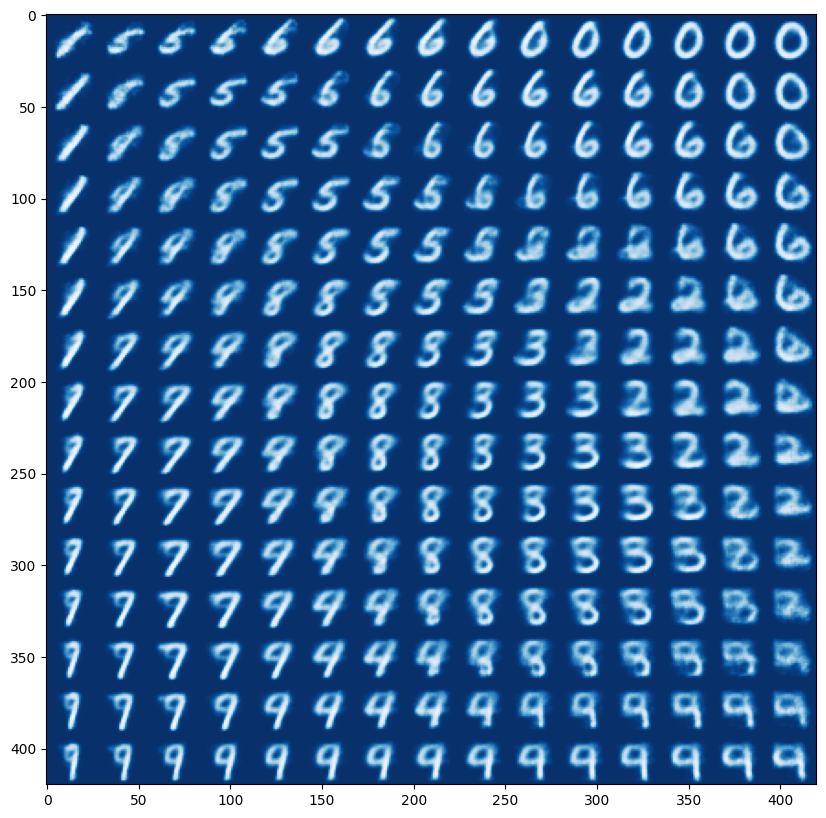

In [8]:
# Define parameters for generating image grid
n = 15
digit_size = 28

# Create empty image grid
figure = np.zeros((digit_size * n, digit_size * n))

# Generate array of normally distributed values for latent variables
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# Generate images for each point in the grid
for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)  # Replicate z_sample for each image in batch

    x_decoded = decoder.predict(z_sample, batch_size=batch_size)  # Use decoder to generate image from z_sample

    digit = x_decoded[0].reshape(digit_size, digit_size)  # Reshape image to digit_size x digit_size

    # Add digit to the image grid
    figure[i * digit_size: (i + 1) * digit_size,
           j * digit_size: (j + 1) * digit_size] = digit

# Display and save the image grid
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Blues_r')
plt.savefig('Results/vae.png', bbox_inches='tight', transparent=True)
plt.show()